### just selection using neural networks

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def generate_embedding_space(n_points=100):
    cluster1 = np.random.normal(loc=[-2, -2], scale=0.5, size=(n_points//2, 2))
    cluster2 = np.random.normal(loc=[2, 2], scale=0.5, size=(n_points//2, 2))
    embeddings = np.vstack([cluster1, cluster2])
    return torch.FloatTensor(embeddings)

In [17]:
class PointSelector(nn.Module):
    def __init__(self):
        super(PointSelector, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    
def calculate_batch_distance_loss(embeddings, selections, top_k=5):
    """Calculate loss based on distances between selected points in a batch"""
    batch_size = embeddings.shape[0]
    
    # Get top k selections
    _, top_indices = torch.topk(selections.squeeze(), k=min(top_k, batch_size))
    selected_points = embeddings[top_indices]
    
    # Calculate pairwise distances between selected points
    distances = torch.pdist(selected_points)
    
    # Loss is negative mean of distances (we want to maximize distances)
    distance_loss = -torch.mean(distances)
    
    # Add regularization to prevent selecting the same point multiple times
    selection_loss = torch.mean(selections)
    
    return distance_loss + 0.1 * selection_loss


def train_selector(model, embeddings, batch_size=32, n_epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=0.000001)
    dataset = TensorDataset(embeddings)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        num_batches = 0
        
        for batch in dataloader:
            batch_embeddings = batch[0]
            optimizer.zero_grad()
            
            # Get selections for this batch
            selections = model(batch_embeddings)
            
            # Calculate loss
            loss = calculate_batch_distance_loss(batch_embeddings, selections)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")
    
    return losses

In [18]:
def find_max_distance_points(embeddings_np, k=5):
    """Find k points that maximize the sum of pairwise distances."""
    n_points = len(embeddings_np)
    best_points = None
    max_total_distance = -1
    
    # Try 1000 random combinations to find a good solution
    for _ in range(1000):
        # Randomly select k points
        indices = np.random.choice(n_points, k, replace=False)
        points = embeddings_np[indices]
        
        # Calculate sum of pairwise distances
        total_distance = sum(np.linalg.norm(p1 - p2) 
                           for p1, p2 in combinations(points, 2))
        
        if total_distance > max_total_distance:
            max_total_distance = total_distance
            best_points = indices
    
    return best_points

def plot_results(embeddings, nn_selections, losses, model):
    plt.figure(figsize=(20, 5))
    embeddings_np = embeddings.detach().numpy()
    
    # Plot 1: Neural network selections
    plt.subplot(1, 4, 1)
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
               c='lightgray', label='Not Selected', alpha=0.5)
    
    # Get top 5 points based on neural network selection
    selections_np = nn_selections.detach().numpy()
    top_5_indices = np.argsort(selections_np.squeeze())[-5:]
    
    # Plot selected points
    selected_points = embeddings_np[top_5_indices]
    plt.scatter(selected_points[:, 0], selected_points[:, 1],
               c='red', label='Top 5 Selected', alpha=0.8, s=100)
    
    # Draw lines between selected points
    for i, j in combinations(range(len(selected_points)), 2):
        plt.plot([selected_points[i, 0], selected_points[j, 0]],
                [selected_points[i, 1], selected_points[j, 1]],
                'r--', alpha=0.2)
    
    plt.title('Neural Network Top 5 Selection')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Maximum distance points
    plt.subplot(1, 4, 2)
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
               c='lightgray', label='Not Selected', alpha=0.5)
    
    # Find and plot maximum distance points
    max_dist_indices = find_max_distance_points(embeddings_np)
    max_dist_points = embeddings_np[max_dist_indices]
    
    plt.scatter(max_dist_points[:, 0], max_dist_points[:, 1],
               c='blue', label='Max Distance Points', alpha=0.8, s=100)
    
    # Draw lines between max distance points
    for i, j in combinations(range(len(max_dist_points)), 2):
        plt.plot([max_dist_points[i, 0], max_dist_points[j, 0]],
                [max_dist_points[i, 1], max_dist_points[j, 1]],
                'b--', alpha=0.2)
    
    plt.title('Maximum Distance Points')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Training loss
    plt.subplot(1, 4, 3)
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot 4: Selection probability heatmap
    plt.subplot(1, 4, 4)
    x = np.linspace(min(embeddings_np[:, 0]), max(embeddings_np[:, 0]), 100)
    y = np.linspace(min(embeddings_np[:, 1]), max(embeddings_np[:, 1]), 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.FloatTensor(np.column_stack((X.ravel(), Y.ravel())))
    
    with torch.no_grad():
        Z = model(grid_points).numpy().reshape(X.shape)
    
    plt.imshow(Z, extent=[min(x), max(x), min(y), max(y)],
               origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label='Selection Probability')
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
               c='white', alpha=0.5, s=20)
    plt.title('Selection Probability Heatmap')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()
    
    # Print distance metrics for comparison
    nn_total_distance = sum(np.linalg.norm(p1 - p2)
                          for p1, p2 in combinations(selected_points, 2))
    max_dist_total = sum(np.linalg.norm(p1 - p2)
                       for p1, p2 in combinations(max_dist_points, 2))
    
    print(f"\nTotal pairwise distances:")
    print(f"Neural Network Selection: {nn_total_distance:.2f}")
    print(f"Maximum Distance Points: {max_dist_total:.2f}")


Epoch 200, Loss: -0.6112
Epoch 400, Loss: -1.0799
Epoch 600, Loss: -0.6740
Epoch 800, Loss: -0.6170
Epoch 1000, Loss: -1.0801
Epoch 1200, Loss: -0.6146
Epoch 1400, Loss: -1.0803
Epoch 1600, Loss: -0.7700
Epoch 1800, Loss: -1.0525
Epoch 2000, Loss: -0.5750
Epoch 2200, Loss: -0.9028
Epoch 2400, Loss: -0.8970
Epoch 2600, Loss: -0.8570
Epoch 2800, Loss: -0.6122
Epoch 3000, Loss: -0.5626
Epoch 3200, Loss: -0.6764
Epoch 3400, Loss: -0.9997
Epoch 3600, Loss: -1.0057
Epoch 3800, Loss: -0.9554
Epoch 4000, Loss: -0.8045
Epoch 4200, Loss: -0.7079
Epoch 4400, Loss: -0.7028
Epoch 4600, Loss: -0.9916
Epoch 4800, Loss: -0.6840
Epoch 5000, Loss: -0.8531
Epoch 5200, Loss: -0.5080
Epoch 5400, Loss: -0.7816
Epoch 5600, Loss: -0.9916
Epoch 5800, Loss: -0.5627
Epoch 6000, Loss: -0.5906
Epoch 6200, Loss: -0.7577
Epoch 6400, Loss: -0.5458
Epoch 6600, Loss: -1.1075
Epoch 6800, Loss: -1.1516
Epoch 7000, Loss: -0.7993
Epoch 7200, Loss: -0.5032
Epoch 7400, Loss: -0.6876
Epoch 7600, Loss: -0.7984
Epoch 7800, Loss

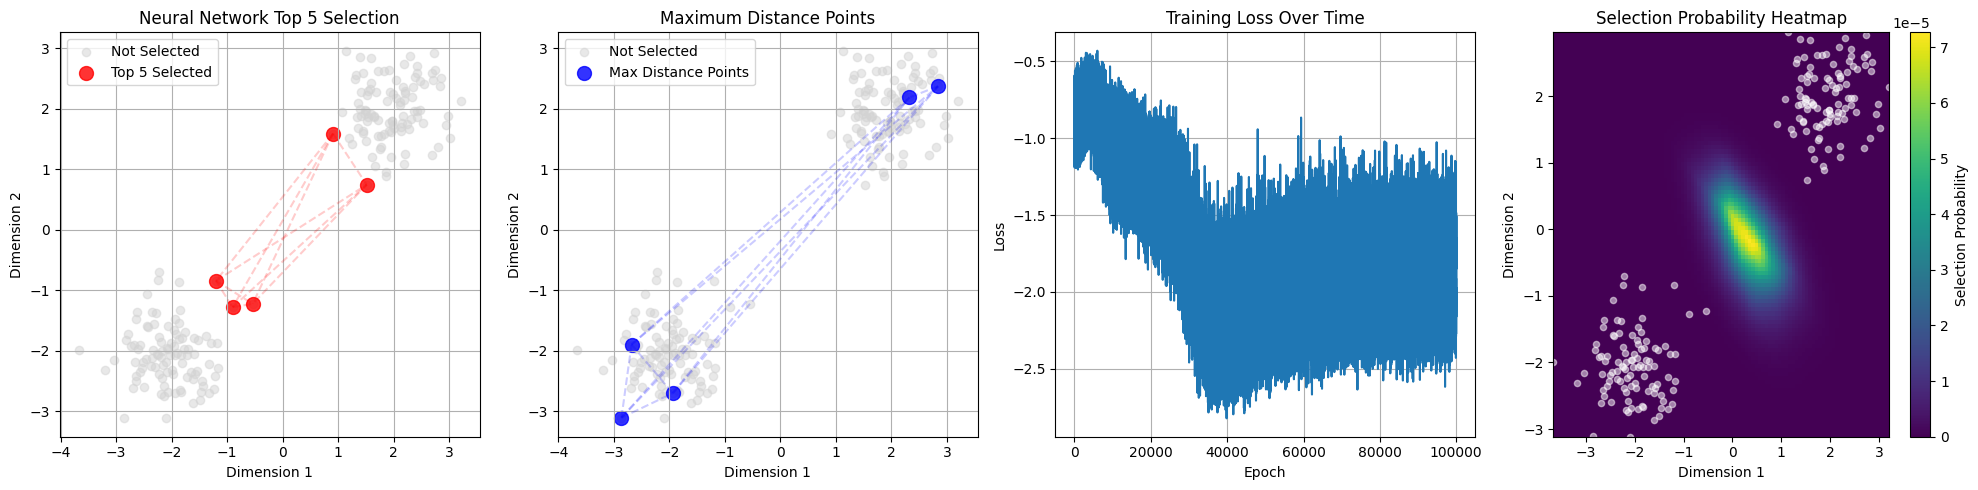


Total pairwise distances:
Neural Network Selection: 21.62
Maximum Distance Points: 46.10


In [19]:
if __name__ == "__main__":
    # Generate embedding space
    embeddings = generate_embedding_space(200)
    
    # Create and train the model
    model = PointSelector()
    losses = train_selector(model, embeddings,n_epochs=100000)
    
    # Get neural network selections
    with torch.no_grad():
        selections = model(embeddings)
    
    # Visualize results
    plot_results(embeddings, selections, losses, model)

### usign qs-selector

In [5]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import Markdown

from selector.methods.distance import MaxMin, MaxSum, OptiSim, DISE
from selector.measures.diversity import compute_diversity

In [6]:
import numpy as np
np.random.seed(42)

#### utility for plotting graph

In [7]:
def graph_data(
    data,
    indices=None,
    labels=None,
    reference=False,
    title="",
    xlabel="",
    ylabel="",
    number=False,
    fname=None,
):
    """Graphs the data in a scatter plot.

    Parameters
    ----------
    data : numpy.ndarray of shape (n_samples, 2)
        The original data points to be graphed.
    indices : list of numpy.ndarray, optional
        List of indices array of the data points selected.
    labels : list of str, optional
        List of labels denoting method for selected indices.
    reference : bool, optional
        Whether to highlight the first data point.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label of the x-axis.
    ylabel : str, optional
        The label of the y-axis.
    number : bool, optional
        Whether to label the selected data points with numbers representing the order of selection.
    fname : str, optional
        Filename for saving the figure. If None, figure is shown.

    """
    if data.ndim != 2 or data.shape[1] != 2:
        raise ValueError(f"Expect data to be a 2D array with 2 columns, got {data.shape}.")

    if labels is not None and len(indices) != len(labels):
        raise ValueError(
            f"Expect indices and labels to have the same length, got {len(indices)} and {len(labels)}."
        )

    # Add a title and axis labels
    plt.figure(dpi=100)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # plot original data
    plt.scatter(data[:, 0], data[:, 1], marker="o", facecolors="none", edgecolors="0.75")

    colors = ["skyblue", "r", "b", "k", "g", "orange", "navy", "indigo", "pink", "purple", "yellow"]
    markers = ["o", "x", "*", "_", "|", "s", "p", ">", "<", "^", "v"]
    text_location = [(0.1, 0.1), (-0.1, 0.1)]
    colors_numbers = ["black", "red", "blue", "k", "k", "k", "k", "k", "k", "k", "k"]

    if indices:
        for index, selected_index in enumerate(indices):
            plt.scatter(
                data[selected_index, 0],
                data[selected_index, 1],
                c=colors[index],
                label=labels[index] if labels is not None else None,
                marker=markers[index],
            )
            if number:
                shift_x, shift_y = text_location[index]
                for i, mol_id in enumerate(selected_index):
                    plt.text(
                        data[mol_id, 0] + shift_x,
                        data[mol_id, 1] + shift_y,
                        str(i + 1),
                        c=colors_numbers[index],
                    )
    if reference:
        plt.scatter(data[0, 0], data[0, 1], c="black")
    if labels is not None:
        # plt.legend(loc="upper left", frameon=False)
        plt.legend(loc="best", frameon=False)
    if fname is not None:
        plt.savefig(fname, dpi=500)
    else:
        plt.show()

In [8]:
# define function to render tables easier


def render_table(data, caption=None, decimals=3):
    """Renders a list of lists in ta markdown table for easy visualization.

    Parameters
    ----------
    data : list of lists
        The data to be rendered in a table, each inner list represents a row with the first row
        being the header.
    caption : str, optional
        The caption of the table.
    decimals : int, optional
        The number of decimal places to round the data to.
    """

    # check all rows have the same number of columns
    if not all(len(row) == len(data[0]) for row in data):
        raise ValueError("Expect all rows to have the same number of columns.")

    if caption is not None:
        # check if caption is a string
        if not isinstance(caption, str):
            raise ValueError("Expect caption to be a string.")
        tmp_output = f"**{caption}**\n\n"

    # get the width of each column (transpose the data list and get the max length of each new row)
    colwidths = [max(len(str(s)) for s in col) + 2 for col in zip(*data)]

    # construct the header row
    header = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(data[0], colwidths))} |"
    tmp_output += header + "\n"

    # construct a separator row
    separator = f"|{'|'.join(['-' * w for w in colwidths])}|"
    tmp_output += separator + "\n"

    # construct the data rows
    for row in data[1:]:
        # round the data to the specified number of decimal places
        row = [round(s, decimals) if isinstance(s, float) else s for s in row]
        row_str = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(row, colwidths))} |"
        tmp_output += row_str + "\n"

    return display(Markdown(tmp_output))

#### making artificaial data using blobs from sklearn

In [9]:
# generate n_sample data in 2D feature space forming 1 cluster
X, labels = make_blobs(
    n_samples=500,
    n_features=2,
    centers=np.array([[0.0, 0.0]]),
    random_state=42,
)

# compute the (n_sample, n_sample) pairwise distance matrix
X_dist = pairwise_distances(X, metric="euclidean")

print("Shape of data   = ", X.shape)
print("Shape of labels = ", labels.shape)
print("Unique labels   = ", np.unique(labels))
print("Cluster size    = ", np.count_nonzero(labels == 0))
print("Shape of the distance array = ", X_dist.shape)

Shape of data   =  (500, 2)
Shape of labels =  (500,)
Unique labels   =  [0]
Cluster size    =  500
Shape of the distance array =  (500, 500)


### using DPP model to select the points and also plot the probablity distribution for the points

#### setup code for single and multiple dpp

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from dppy.finite_dpps import FiniteDPP
from scipy.stats import gaussian_kde

In [11]:
def compute_similarity_matrix(X_dist, gamma=0.1):
    """Compute similarity matrix using RBF kernel."""
    return np.exp(-gamma * X_dist ** 2)

def sample_single_dpp(X, X_dist, k=5, gamma=0.1):
    """Perform a single DPP sampling."""
    similarity_matrix = compute_similarity_matrix(X_dist, gamma)
    dpp = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix)
    dpp.sample_exact_k_dpp(size=k)
    selected_indices = dpp.list_of_samples[0]
    return X[selected_indices]

def sample_multiple_dpps(X, X_dist, n_iterations=1000, k=5, gamma=0.1):
    """Perform multiple DPP samplings."""
    all_selected_points = []
    for _ in range(n_iterations):
        selected_points = sample_single_dpp(X, X_dist, k, gamma)
        all_selected_points.extend(selected_points)
    return np.array(all_selected_points)

def plot_single_dpp(X, selected_points, title="Single DPP Sampling"):
    """Plot original points and DPP selected points."""
    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
    plt.scatter(selected_points[:, 0], selected_points[:, 1], 
               color='red', label='Selected points', 
               s=100, edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_probability_distribution(X, all_selected_points, title="DPP Sampling Distribution"):
    """Plot probability distribution of DPP sampling."""
    # Create a grid for the heatmap
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Calculate KDE
    values = np.vstack([all_selected_points[:, 0], all_selected_points[:, 1]])
    kernel = gaussian_kde(values)
    z = np.reshape(kernel(positions), xx.shape)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(np.rot90(z), cmap='viridis', 
              extent=[x_min, x_max, y_min, y_max])
    plt.colorbar(label='Probability Density')
    plt.scatter(X[:, 0], X[:, 1], color='white', alpha=0.3, s=20)
    plt.title(title, fontsize=16)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.show()

#### testing with differnt gamma and plotting points

In [24]:
k=5
gamma=4
n_iterations=10000

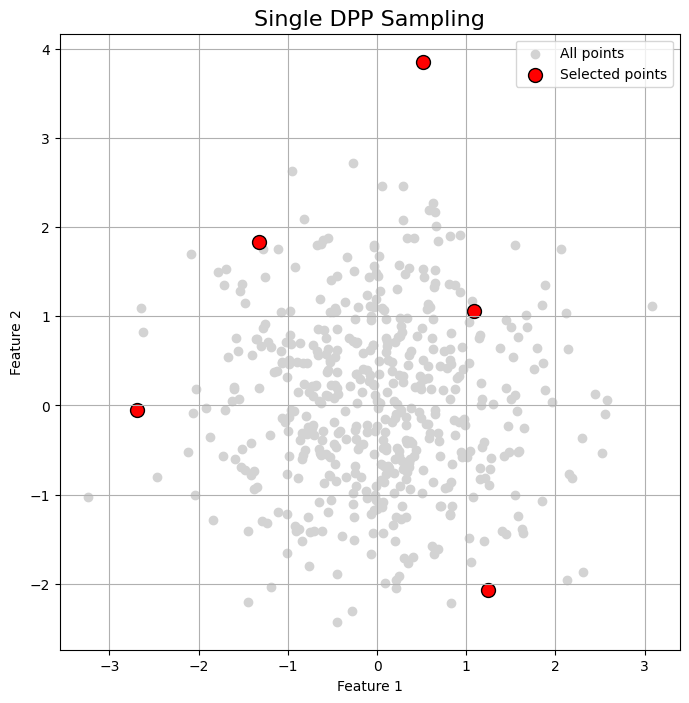

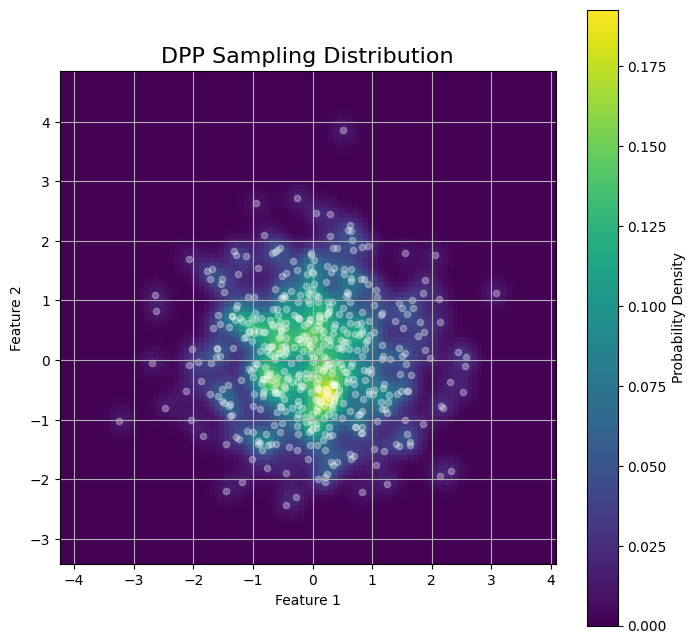

In [25]:
selected_points = sample_single_dpp(X, X_dist)
plot_single_dpp(X, selected_points)

all_selected_points = sample_multiple_dpps(X, X_dist,n_iterations=n_iterations,k=k,gamma=gamma)
plot_probability_distribution(X, all_selected_points)

In [28]:
k=5
gamma=0.1
n_iterations=10000

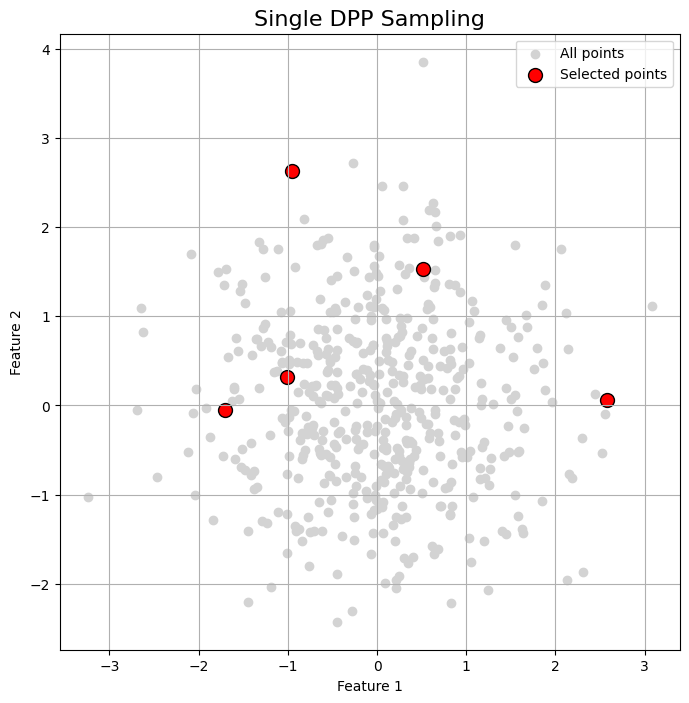

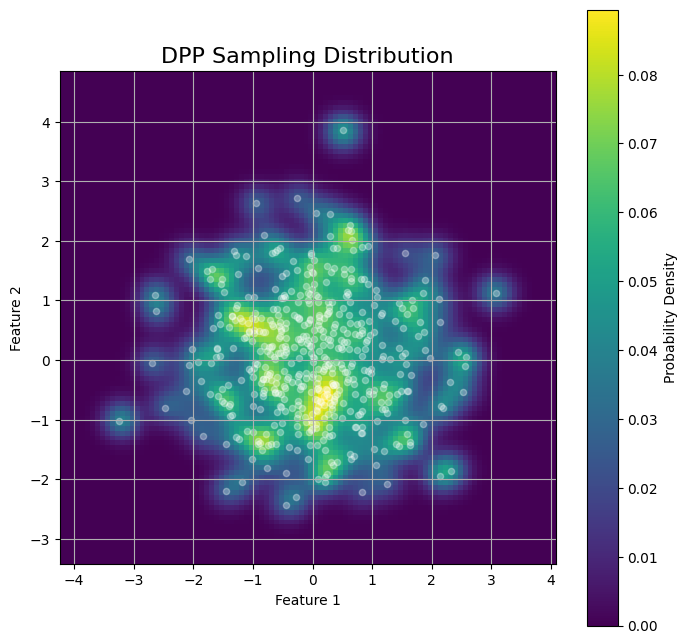

In [29]:
selected_points = sample_single_dpp(X, X_dist)
plot_single_dpp(X, selected_points)

all_selected_points = sample_multiple_dpps(X, X_dist,n_iterations=n_iterations,k=k,gamma=gamma)
plot_probability_distribution(X, all_selected_points)

testing with the hyper parameters taht are gamma

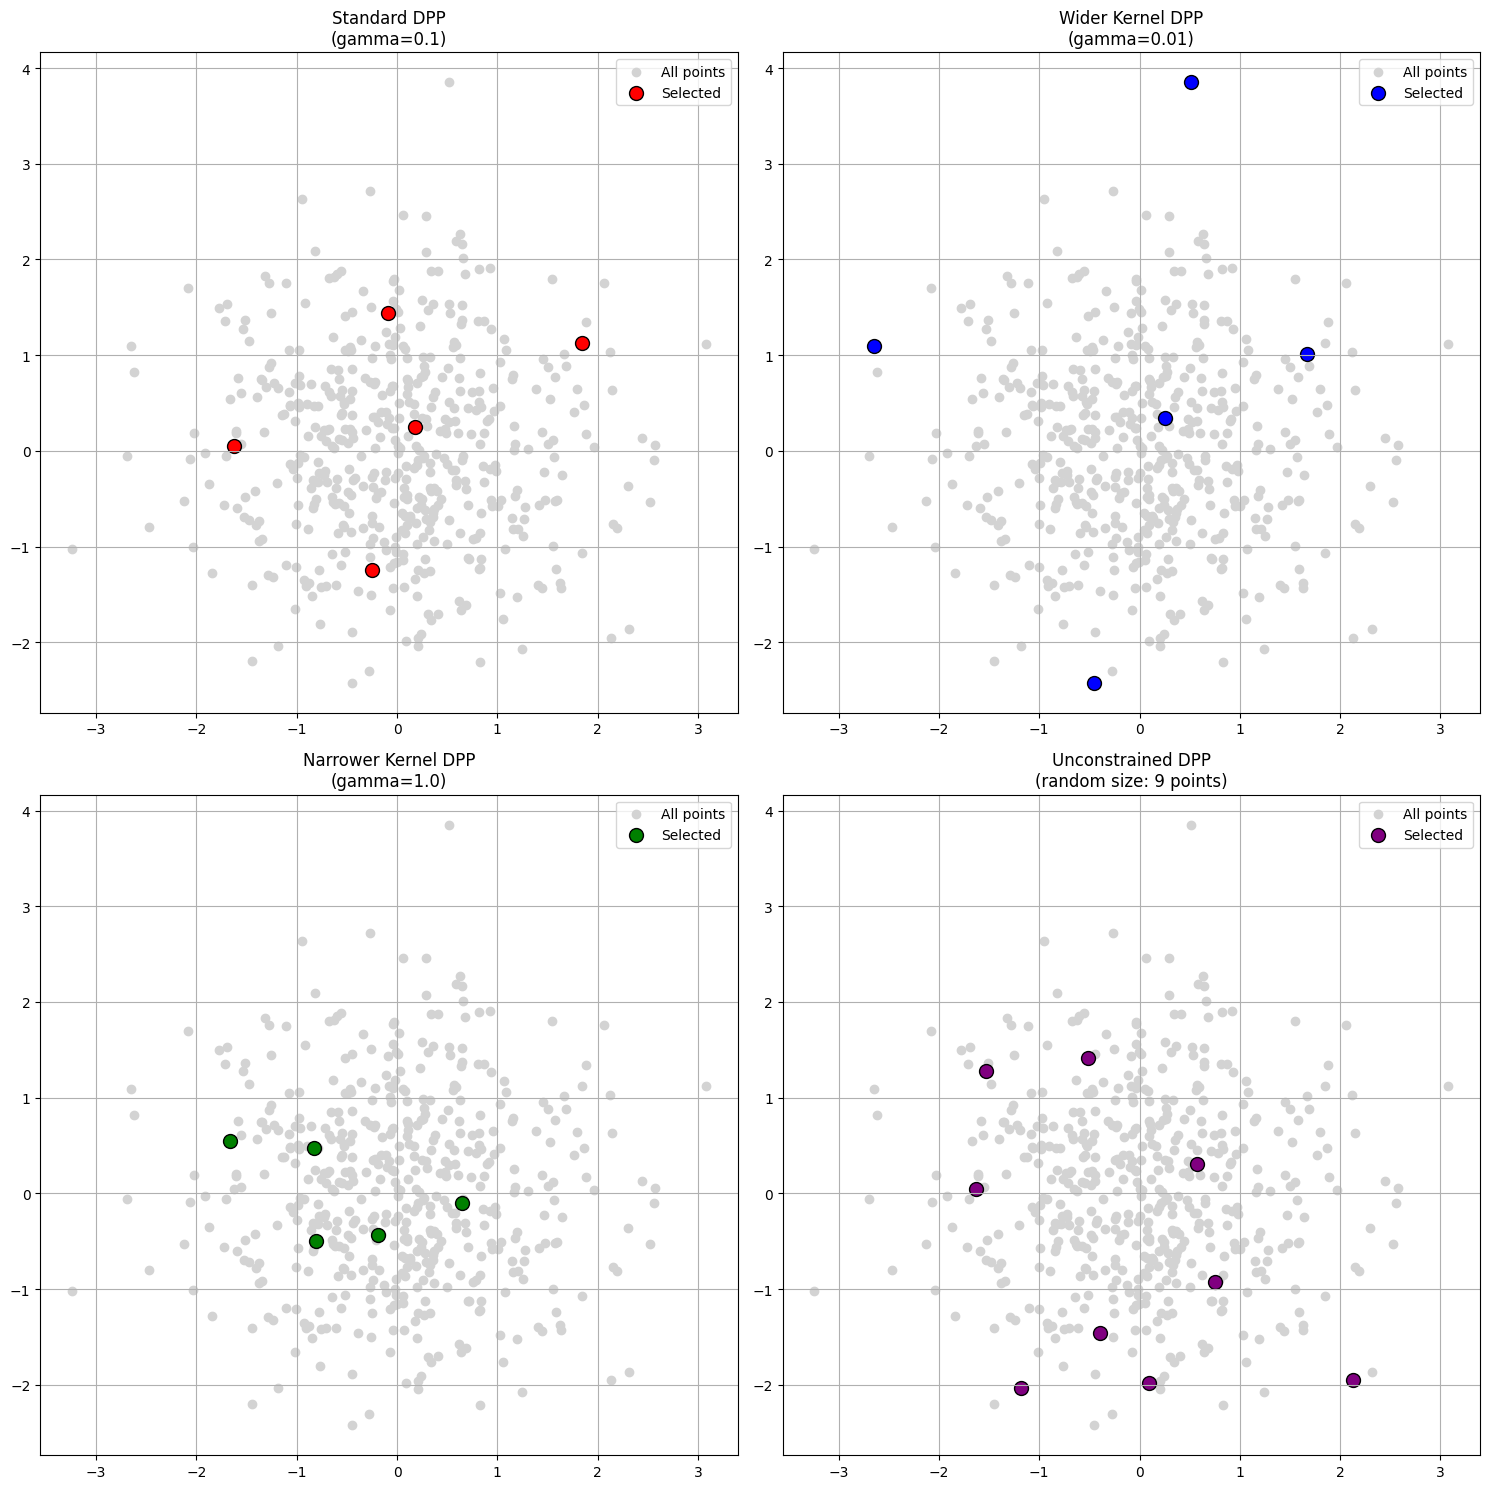

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from dppy.finite_dpps import FiniteDPP

def compare_dpp_parameters(X, X_dist):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    # 1. Standard DPP with likelihood kernel (gamma = 0.1)
    similarity_matrix1 = np.exp(-0.1 * X_dist ** 2)
    dpp1 = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix1)
    dpp1.sample_exact_k_dpp(size=5)
    axs[0,0].scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
    selected_points = X[dpp1.list_of_samples[0]]
    axs[0,0].scatter(selected_points[:, 0], selected_points[:, 1], 
                     color='red', label='Selected', s=100, edgecolor='black')
    axs[0,0].set_title('Standard DPP\n(gamma=0.1)')
    axs[0,0].legend()
    axs[0,0].grid(True)
    
    # 2. Smaller gamma (0.01) - more spread out
    similarity_matrix2 = np.exp(-0.001 * X_dist ** 2)
    dpp2 = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix2)
    dpp2.sample_exact_k_dpp(size=5)
    axs[0,1].scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
    selected_points = X[dpp2.list_of_samples[0]]
    axs[0,1].scatter(selected_points[:, 0], selected_points[:, 1], 
                     color='blue', label='Selected', s=100, edgecolor='black')
    axs[0,1].set_title('Wider Kernel DPP\n(gamma=0.001)')
    axs[0,1].legend()
    axs[0,1].grid(True)
    
    # 3. Larger gamma (1.0) - more local
    similarity_matrix3 = np.exp(-4.0 * X_dist ** 2)
    dpp3 = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix3)
    dpp3.sample_exact_k_dpp(size=5)
    axs[1,0].scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
    selected_points = X[dpp3.list_of_samples[0]]
    axs[1,0].scatter(selected_points[:, 0], selected_points[:, 1], 
                     color='green', label='Selected', s=100, edgecolor='black')
    axs[1,0].set_title('Narrower Kernel DPP\n(gamma=4.0)')
    axs[1,0].legend()
    axs[1,0].grid(True)
    
    # 4. Unconstrained size sampling
    similarity_matrix4 = np.exp(-0.1 * X_dist ** 2)
    dpp4 = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix4)
    dpp4.sample_exact()
    axs[1,1].scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
    selected_points = X[dpp4.list_of_samples[0]]
    axs[1,1].scatter(selected_points[:, 0], selected_points[:, 1], 
                     color='purple', label='Selected', s=100, edgecolor='black')
    axs[1,1].set_title(f'Unconstrained DPP\n(random size: {len(dpp4.list_of_samples[0])} points)')
    axs[1,1].legend()
    axs[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
compare_dpp_parameters(X, X_dist)

#### adding liked points into idea

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from dppy.finite_dpps import FiniteDPP
from scipy.stats import gaussian_kde

def compute_weighted_similarity_matrix_multi_targets(data, target_points, gamma=0.1, beta=0.5):
    """Original similarity matrix computation with target points"""
    total_weights = np.zeros(len(data))
    for target_point in target_points:
        distances_to_target = np.linalg.norm(data - target_point, axis=1)
        weights = np.exp(-beta * distances_to_target**2)
        total_weights += weights
    
    pairwise_distances_matrix = pairwise_distances(data, metric="euclidean")
    similarity_matrix = np.exp(-gamma * pairwise_distances_matrix**2)
    weighted_similarity_matrix = similarity_matrix * total_weights[:, np.newaxis]
    symmetrized_matrix = (weighted_similarity_matrix + weighted_similarity_matrix.T) / 2
    
    eig_vals, eig_vecs = np.linalg.eigh(symmetrized_matrix)
    eig_vals_clipped = np.clip(eig_vals, 0, None)
    psd_matrix = eig_vecs @ np.diag(eig_vals_clipped) @ eig_vecs.T
    
    return psd_matrix

def sample_multiple_targeted_dpps(X, target_points, n_iterations=1000, k=10, gamma=0.1, beta=0.5):
    """Perform multiple DPP samplings with target points"""
    all_selected_points = []
    
    for _ in range(n_iterations):
        # Compute similarity matrix with target points
        similarity_matrix = compute_weighted_similarity_matrix_multi_targets(X, target_points, gamma, beta)
        
        # Sample from DPP
        dpp = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix)
        dpp.sample_exact_k_dpp(size=k)
        selected_indices = dpp.list_of_samples[0]
        
        all_selected_points.extend(X[selected_indices])
    
    return np.array(all_selected_points)

def plot_probability_distribution_with_targets(X, all_selected_points, target_points, 
                                            title="DPP Sampling Distribution with Target Points"):
    """Plot probability distribution of DPP sampling including target points"""
    # Create a grid for the heatmap
    x_min, x_max = min(X[:, 0].min(), target_points[:, 0].min()) - 1, max(X[:, 0].max(), target_points[:, 0].max()) + 1
    y_min, y_max = min(X[:, 1].min(), target_points[:, 1].min()) - 1, max(X[:, 1].max(), target_points[:, 1].max()) + 1
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Calculate KDE for the selected points
    values = np.vstack([all_selected_points[:, 0], all_selected_points[:, 1]])
    kernel = gaussian_kde(values)
    z = np.reshape(kernel(positions), xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 10))
    
    # Plot the probability density heatmap
    plt.imshow(np.rot90(z), cmap='viridis',
              extent=[x_min, x_max, y_min, y_max],
              aspect='auto')
    plt.colorbar(label='Probability Density')
    
    # Plot original points
    plt.scatter(X[:, 0], X[:, 1], color='white', alpha=0.3, s=20, label='Original Points')
    
    # Plot target points
    plt.scatter(target_points[:, 0], target_points[:, 1], 
               color='red', marker='x', s=200, linewidth=3, 
               label='Target Points')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
def analyze_dpp_distribution(X, target_points, n_iterations=1000, k=10, gamma=0.1, beta=0.5):
    """Analyze and visualize the DPP sampling distribution"""
    # Perform multiple samplings
    all_selected_points = sample_multiple_targeted_dpps(X, target_points, 
                                                      n_iterations=n_iterations,
                                                      k=k, gamma=gamma, beta=beta)
    
    # Plot the probability distribution
    plot_probability_distribution_with_targets(X, all_selected_points, target_points,
                                            title=f"DPP Sampling Distribution\n({n_iterations} iterations, k={k})")
    
    return all_selected_points

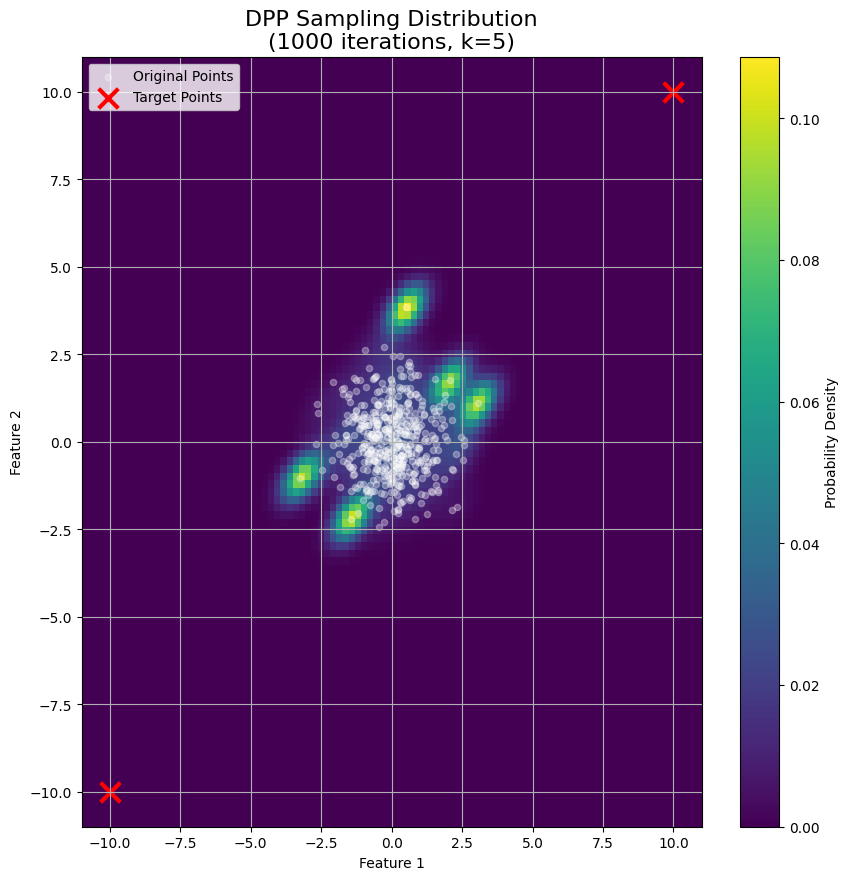

In [37]:
# Assuming X and target_points are already defined
n_iterations = 1000  # Number of DPP samples to generate
k = 5 # Number of points to select in each sampling
gamma = 0.1  # RBF kernel parameter
beta = 0.5  # Target point weight parameter
target_points = np.array([[-10.0, -10.0],[10,10]])  # Favor these points

# Run the analysis
all_selected_points = analyze_dpp_distribution(X, target_points, 
                                             n_iterations=n_iterations,
                                             k=k, gamma=gamma, beta=beta)

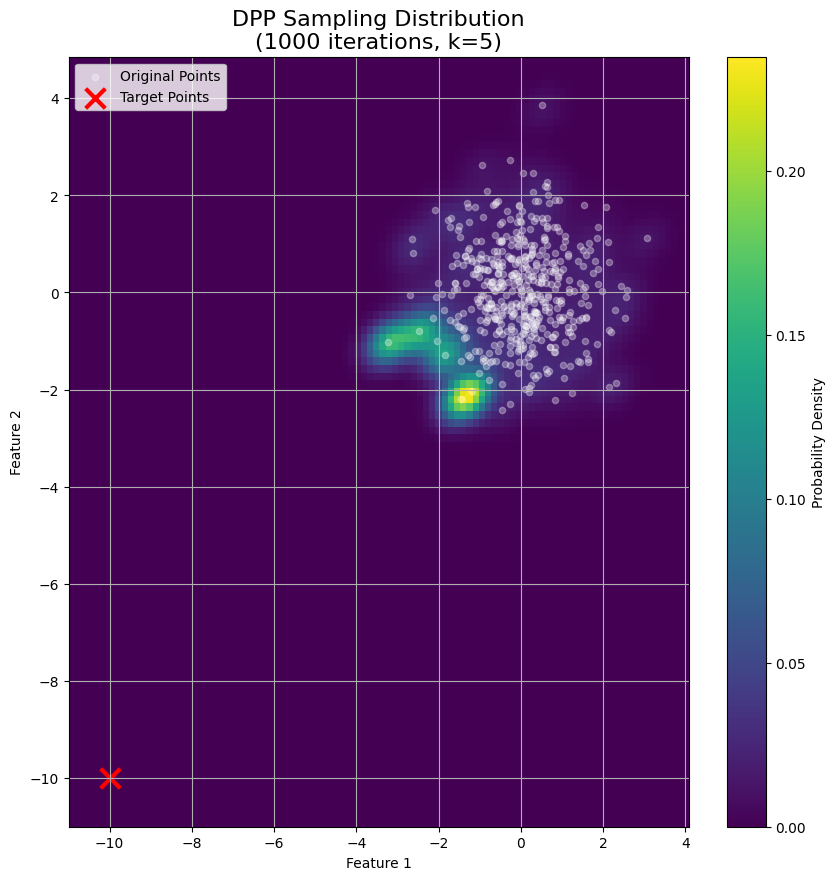

In [38]:
# Assuming X and target_points are already defined
n_iterations = 1000  # Number of DPP samples to generate
k = 5 # Number of points to select in each sampling
gamma = 0.01  # RBF kernel parameter
beta = 0.5  # Target point weight parameter
target_points = np.array([[-10.0, -10.0]])  # Favor these points

# Run the analysis
all_selected_points = analyze_dpp_distribution(X, target_points, 
                                             n_iterations=n_iterations,
                                             k=k, gamma=gamma, beta=beta)

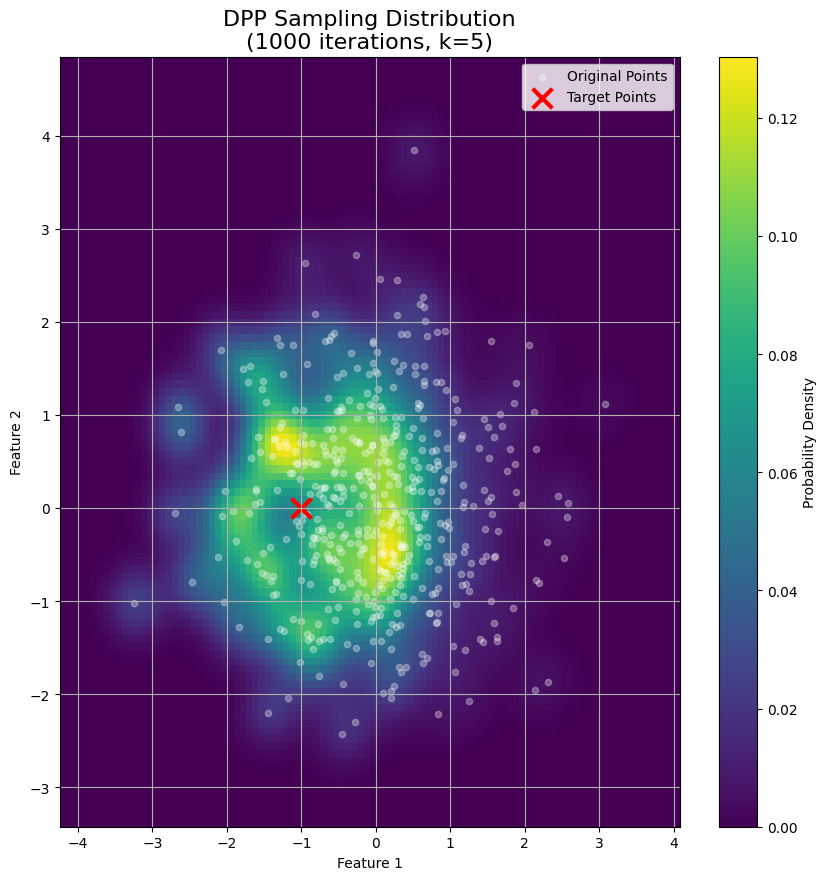

In [39]:
# Assuming X and target_points are already defined
n_iterations = 1000  # Number of DPP samples to generate
k = 5 # Number of points to select in each sampling
gamma = 0.1  # RBF kernel parameter
beta = 0.5  # Target point weight parameter
target_points = np.array([[-1.0, 0]])  # Favor these points

# Run the analysis
all_selected_points = analyze_dpp_distribution(X, target_points, 
                                             n_iterations=n_iterations,
                                             k=k, gamma=gamma, beta=beta)

changing teh similarity matrix

In [40]:
def compute_weighted_similarity_matrix_multi_targets_corrected(data, target_points, gamma=0.1, beta=0.5):
    """
    Compute similarity matrix with target point influence using a mathematically
    sound approach that maintains kernel properties.
    """
    # Compute weights for target points using softmax to normalize
    total_weights = np.zeros(len(data))
    for target_point in target_points:
        distances_to_target = np.linalg.norm(data - target_point, axis=1)
        weights = np.exp(-beta * distances_to_target**2)
        total_weights += weights
    
    # Normalize weights to [0,1] range
    normalized_weights = total_weights / total_weights.max()
    
    # Compute base similarity matrix
    pairwise_distances_matrix = pairwise_distances(data, metric="euclidean")
    
    # Modified kernel that incorporates weights symmetrically
    # K'(x,y) = sqrt(w(x)w(y)) * K(x,y)
    weight_products = np.sqrt(normalized_weights[:, np.newaxis] * normalized_weights[np.newaxis, :])
    similarity_matrix = np.exp(-gamma * pairwise_distances_matrix**2) * weight_products
    
    # Ensure numerical stability and PSD property
    eig_vals, eig_vecs = np.linalg.eigh(similarity_matrix)
    eig_vals_clipped = np.clip(eig_vals, 0, None)  # Set negative eigenvalues to 0
    psd_matrix = eig_vecs @ np.diag(eig_vals_clipped) @ eig_vecs.T
    
    return psd_matrix

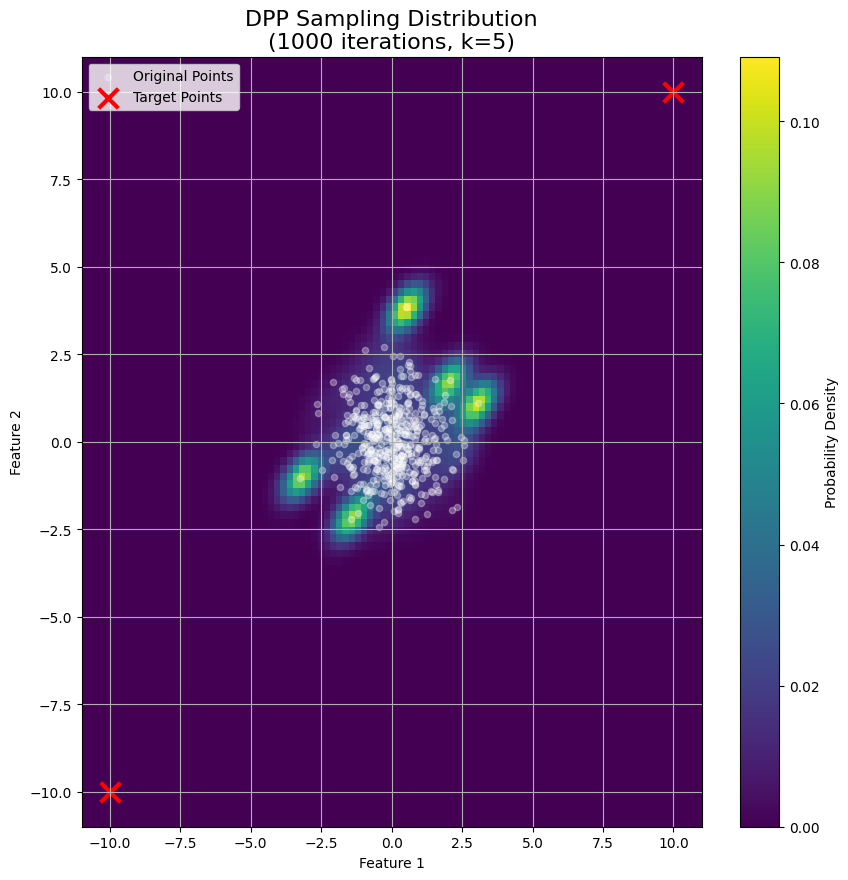

In [41]:
# Assuming X and target_points are already defined
n_iterations = 1000  # Number of DPP samples to generate
k = 5 # Number of points to select in each sampling
gamma = 0.1  # RBF kernel parameter
beta = 0.5  # Target point weight parameter
target_points = np.array([[-10.0, -10.0],[10,10]])  # Favor these points

# Run the analysis
all_selected_points = analyze_dpp_distribution(X, target_points, 
                                             n_iterations=n_iterations,
                                             k=k, gamma=gamma, beta=beta)

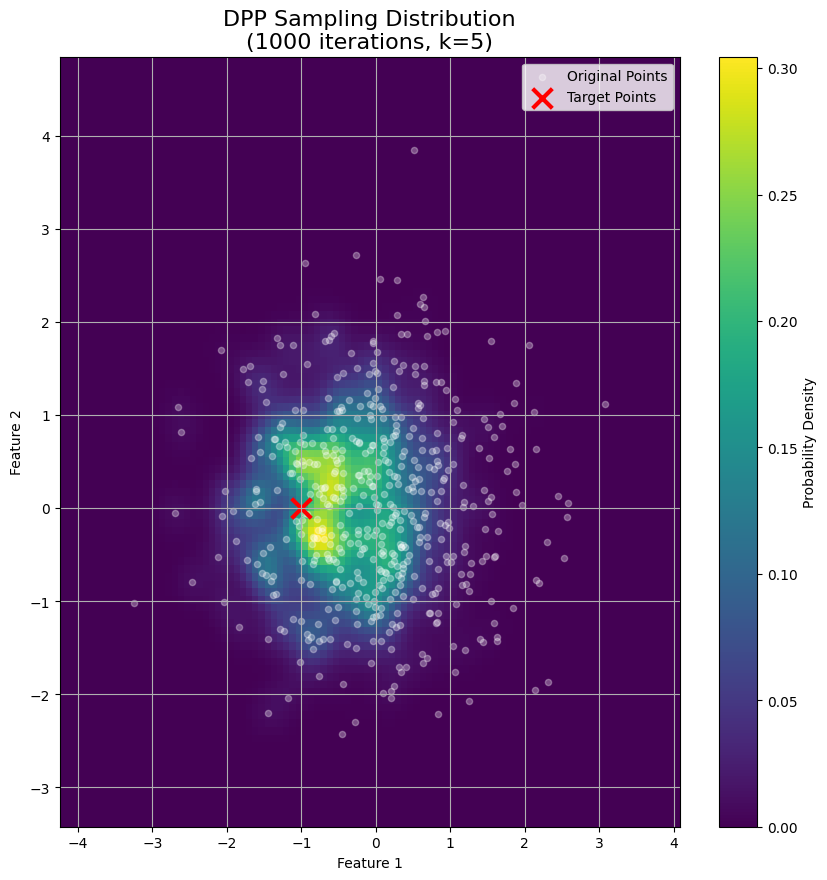

In [42]:
# Assuming X and target_points are already defined
n_iterations = 1000  # Number of DPP samples to generate
k = 5 # Number of points to select in each sampling
gamma = 4  # RBF kernel parameter
beta = 0.5  # Target point weight parameter
target_points = np.array([[-1.0,0]])  # Favor these points

# Run the analysis
all_selected_points = analyze_dpp_distribution(X, target_points, 
                                             n_iterations=n_iterations,
                                             k=k, gamma=gamma, beta=beta)

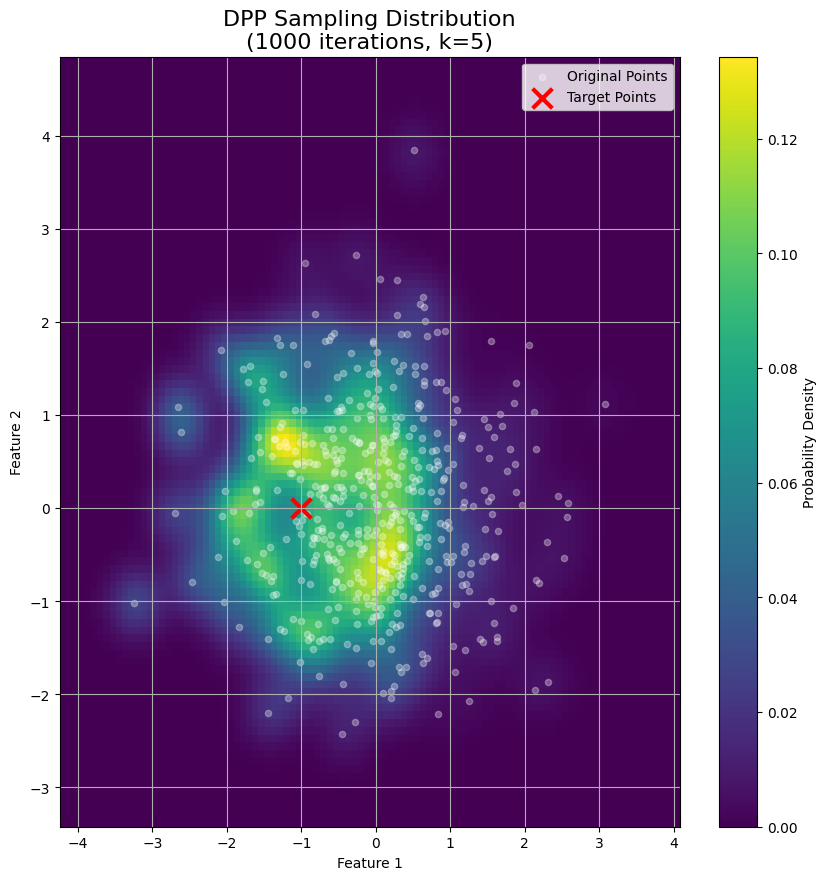

In [43]:
# Assuming X and target_points are already defined
n_iterations = 1000  # Number of DPP samples to generate
k = 5 # Number of points to select in each sampling
gamma = 0.1  # RBF kernel parameter
beta = 0.5  # Target point weight parameter
target_points = np.array([[-1.0, 0]])  # Favor these points

# Run the analysis
all_selected_points = analyze_dpp_distribution(X, target_points, 
                                             n_iterations=n_iterations,
                                             k=k, gamma=gamma, beta=beta)

In [13]:
from typing import List

def compute_similarity_matrix(self, positive_ids: List[str] = None, negative_ids: List[str] = None,
                                gamma: float = 0.1, attract_beta: float = 0.5, repel_beta: float = 0.3):
        """
        Compute similarity matrix with handling for empty preferences
        """
        # Initialize weights to neutral values
        attraction_weights = np.ones(len(self.embedding_matrix))
        repulsion_weights = np.ones(len(self.embedding_matrix))
        
        # Process positive preferences if they exist
        if positive_ids and len(positive_ids) > 0:
            try:
                positive_embeddings = np.stack([self.embeddings[pid] for pid in positive_ids])
                # Compute attraction weights
                for pos_emb in positive_embeddings:
                    distances = np.linalg.norm(self.embedding_matrix - pos_emb, axis=1)
                    weights = np.exp(-attract_beta * distances**2)
                    attraction_weights *= (1 + weights)
            except Exception as e:
                print(f"Error processing positive preferences: {str(e)}")
                # Fallback to neutral weights
                attraction_weights = np.ones(len(self.embedding_matrix))
        
        # Process negative preferences if they exist
        if negative_ids and len(negative_ids) > 0:
            try:
                negative_embeddings = np.stack([self.embeddings[pid] for pid in negative_ids])
                # Compute repulsion weights
                for neg_emb in negative_embeddings:
                    distances = np.linalg.norm(self.embedding_matrix - neg_emb, axis=1)
                    weights = np.exp(-repel_beta * distances**2)
                    repulsion_weights *= (1 - weights)
            except Exception as e:
                print(f"Error processing negative preferences: {str(e)}")
                # Fallback to neutral weights
                repulsion_weights = np.ones(len(self.embedding_matrix))
        
        # Combine weights
        total_weights = attraction_weights * repulsion_weights
        
        # Handle case where all weights are the same
        if np.all(total_weights == total_weights[0]):
            normalized_weights = np.ones_like(total_weights)
        else:
            # Normalize weights only if there's variation
            normalized_weights = (total_weights - total_weights.min()) / (total_weights.max() - total_weights.min())
        
        # Compute kernel matrix
        pairwise_distances_matrix = pairwise_distances(self.embedding_matrix, metric="euclidean")
        weight_products = np.sqrt(normalized_weights[:, np.newaxis] * normalized_weights[np.newaxis, :])
        kernel_matrix = np.exp(-gamma * pairwise_distances_matrix**2) * weight_products
        
        # Ensure numerical stability
        kernel_matrix = np.clip(kernel_matrix, 1e-10, 1.0)
        
        return kernel_matrix

In [14]:
import numpy as np
from sklearn.metrics import pairwise_distances

def compute_dual_influence_similarity_matrix(data, positive_targets, negative_targets, 
                                          gamma=0.1, attract_beta=0.5, repel_beta=0.3):
    """
    Compute similarity matrix that considers both attractive (positive) and repulsive (negative) target points.
    Handles empty target arrays gracefully.
    """
    # Initialize attraction weights
    attraction_weights = np.ones(len(data))
    if len(positive_targets) > 0:
        for target_point in positive_targets:
            distances_to_target = np.linalg.norm(data - target_point, axis=1)
            weights = np.exp(-attract_beta * distances_to_target**2)
            attraction_weights *= (1 + weights)
    
    # Initialize repulsion weights
    repulsion_weights = np.ones(len(data))
    if len(negative_targets) > 0:
        for target_point in negative_targets:
            distances_to_target = np.linalg.norm(data - target_point, axis=1)
            weights = np.exp(-repel_beta * distances_to_target**2)
            repulsion_weights *= (1 - weights)
    
    # Combine attractive and repulsive influences
    total_weights = attraction_weights * repulsion_weights
    
    # Handle normalization when all weights are the same
    weights_min = total_weights.min()
    weights_max = total_weights.max()
    if np.isclose(weights_min, weights_max):
        normalized_weights = np.ones_like(total_weights)
    else:
        normalized_weights = (total_weights - weights_min) / (weights_max - weights_min)
    
    # Compute base similarity matrix
    pairwise_distances_matrix = pairwise_distances(data, metric="euclidean")
    base_similarity = np.exp(-gamma * pairwise_distances_matrix**2)
    
    # Modified kernel incorporating both influences symmetrically
    weight_products = np.sqrt(normalized_weights[:, np.newaxis] * normalized_weights[np.newaxis, :])
    similarity_matrix = base_similarity * weight_products
    
    # Ensure numerical stability and symmetry
    similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2
    
    # Ensure PSD property
    eig_vals, eig_vecs = np.linalg.eigh(similarity_matrix)
    eig_vals_clipped = np.clip(eig_vals, 0, None)
    psd_matrix = eig_vecs @ np.diag(eig_vals_clipped) @ eig_vecs.T
    
    return psd_matrix

def plot_dual_influence_distribution(X, all_selected_points, positive_targets, negative_targets, 
                                   title="DPP Sampling Distribution with Dual Influence"):
    """
    Visualize the sampling distribution with both positive and negative target points.
    Handles empty target arrays gracefully.
    
    Parameters:
    -----------
    X : array-like
        Original data points
    all_selected_points : array-like
        Points selected by multiple DPP samplings
    positive_targets : array-like
        Attractive target points
    negative_targets : array-like
        Repulsive target points
    title : str
        Plot title
    """
    # Create a grid for the heatmap - only use non-empty arrays
    points_to_consider = [X]  # X is always included
    
    if len(positive_targets) > 0:
        points_to_consider.append(positive_targets)
    if len(negative_targets) > 0:
        points_to_consider.append(negative_targets)
    
    all_points = np.vstack(points_to_consider)
    
    x_min, x_max = all_points[:, 0].min() - 1, all_points[:, 0].max() + 1
    y_min, y_max = all_points[:, 1].min() - 1, all_points[:, 1].max() + 1
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Calculate KDE for selected points
    values = np.vstack([all_selected_points[:, 0], all_selected_points[:, 1]])
    kernel = gaussian_kde(values)
    z = np.reshape(kernel(positions), xx.shape)
    
    plt.figure(figsize=(10, 10))
    
    # Plot probability density heatmap
    plt.imshow(np.rot90(z), cmap='viridis',
              extent=[x_min, x_max, y_min, y_max],
              aspect='auto')
    plt.colorbar(label='Probability Density')
    
    # Plot original points
    plt.scatter(X[:, 0], X[:, 1], color='white', alpha=0.3, s=20, label='Original Points')
    
    # Plot positive target points only if they exist
    if len(positive_targets) > 0:
        plt.scatter(positive_targets[:, 0], positive_targets[:, 1], 
                   color='green', marker='*', s=200, linewidth=3, 
                   label='Attractive Points')
    
    # Plot negative target points only if they exist
    if len(negative_targets) > 0:
        plt.scatter(negative_targets[:, 0], negative_targets[:, 1], 
                   color='red', marker='x', s=200, linewidth=3, 
                   label='Repulsive Points')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

def sample_dual_influence_dpps(X, positive_targets, negative_targets, n_iterations=1000, 
                             k=10, gamma=0.1, attract_beta=0.5, repel_beta=0.3):
    """
    Perform multiple DPP samplings with both attractive and repulsive target points.
    """
    all_selected_points = []
    
    for _ in range(n_iterations):
        # Compute similarity matrix with dual influence
        similarity_matrix = compute_dual_influence_similarity_matrix(
            X, positive_targets, negative_targets, gamma, attract_beta, repel_beta
        )
        
        # Sample from DPP
        dpp = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix)
        dpp.sample_exact_k_dpp(size=k)
        selected_indices = dpp.list_of_samples[0]
        
        all_selected_points.extend(X[selected_indices])
    
    return np.array(all_selected_points)

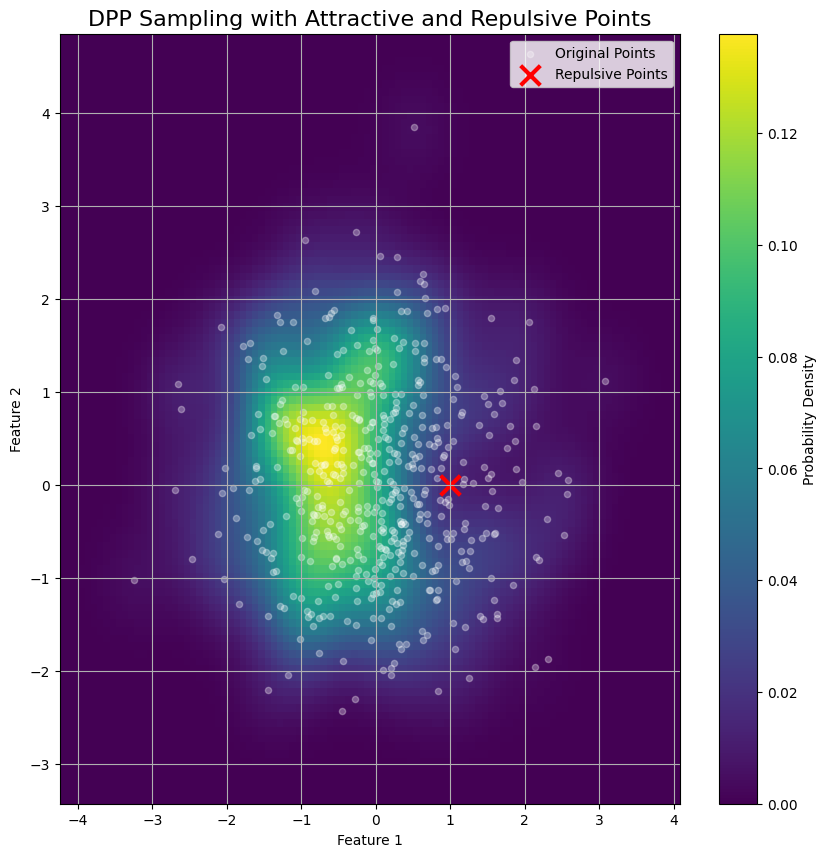

In [15]:
# Example usage
positive_targets = np.array([[0,0],[0.2]])  # Points to be near
negative_targets = np.array([[1,0]])       # Points to avoid

# Run multiple samplings
all_selected_points = sample_dual_influence_dpps(
    X, 
    positive_targets, 
    negative_targets,
    n_iterations=100,
    k=5,
    gamma=4,
    attract_beta=0.5,
    repel_beta=0.3
)

# Visualize the results
plot_dual_influence_distribution(
    X, 
    all_selected_points, 
    positive_targets, 
    negative_targets,
    title="DPP Sampling with Attractive and Repulsive Points"
)

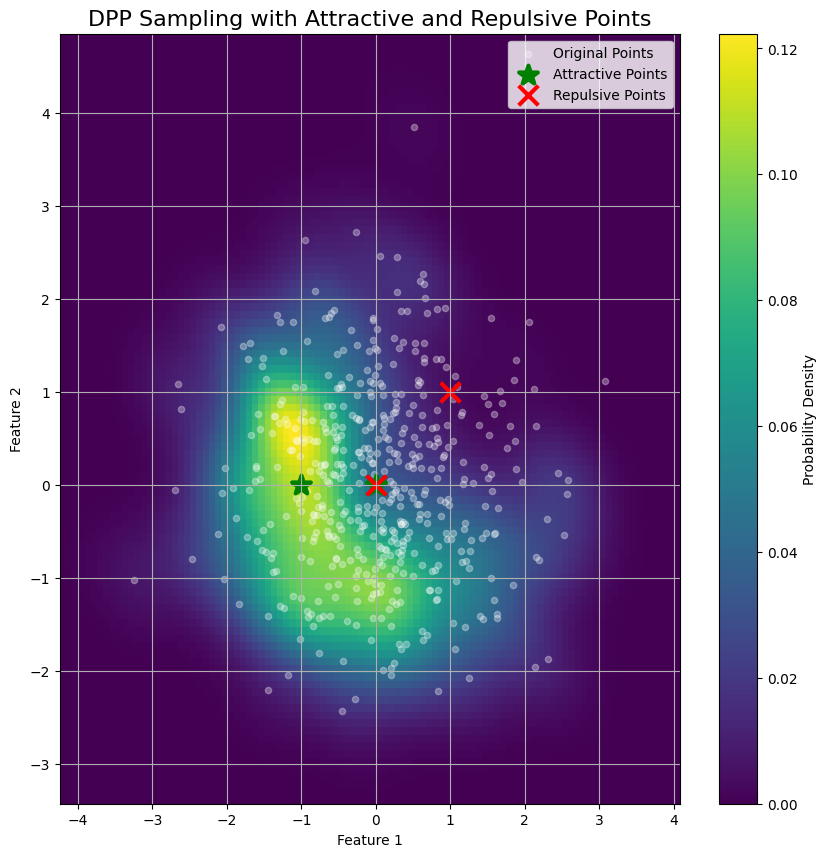

In [16]:
# Example usage
positive_targets = np.array([[-1, 0], [0,0]])  # Points to be near
negative_targets = np.array([[0, 0], [1,1]])       # Points to avoid

# Run multiple samplings
all_selected_points = sample_dual_influence_dpps(
    X, 
    positive_targets, 
    negative_targets,
    n_iterations=100,
    k=5,
    gamma=4,
    attract_beta=0.5,
    repel_beta=0.3
)

# Visualize the results
plot_dual_influence_distribution(
    X, 
    all_selected_points, 
    positive_targets, 
    negative_targets,
    title="DPP Sampling with Attractive and Repulsive Points"
)

In [15]:
# Example usage
positive_targets = np.array([[-1, 0], [0,0]])  # Points to be near
negative_targets = np.array([[1,1]])       # Points to avoid

# Run multiple samplings
all_selected_points = sample_dual_influence_dpps(
    X, 
    positive_targets, 
    negative_targets,
    n_iterations=100,
    k=5,
    gamma=4,
    attract_beta=0.5,
    repel_beta=0.3
)

# Visualize the results
plot_dual_influence_distribution(
    X, 
    all_selected_points, 
    positive_targets, 
    negative_targets,
    title="DPP Sampling with Attractive and Repulsive Points"
)

AttributeError: 'numpy.ndarray' object has no attribute 'embedding_matrix'

In [16]:
# Example usage
positive_targets = np.array([[-1, 0], [0,0]])  # Points to be near
negative_targets = np.array([[1,1]])       # Points to avoid

# Run multiple samplings
all_selected_points = sample_dual_influence_dpps(
    X, 
    positive_targets, 
    negative_targets,
    n_iterations=100,
    k=5,
    gamma=0.1,
    attract_beta=0.5,
    repel_beta=0.3
)

# Visualize the results
plot_dual_influence_distribution(
    X, 
    all_selected_points, 
    positive_targets, 
    negative_targets,
    title="DPP Sampling with Attractive and Repulsive Points"
)

AttributeError: 'numpy.ndarray' object has no attribute 'embedding_matrix'

In [ ]:
import numpy as np
from typing import List, Dict, Any
from sklearn.metrics import pairwise_distances
from dppy.finite_dpps import FiniteDPP

class DPPRecommender:
    def __init__(self, embeddings: Dict[str, np.ndarray], tour_metadata: Dict[str, Dict]):
        self.embeddings = embeddings
        self.tour_metadata = tour_metadata
        self.embedding_matrix = np.stack(list(embeddings.values()))
        self.tour_ids = list(embeddings.keys())
        
    def compute_similarity_matrix(self, positive_ids: List[str] = None, negative_ids: List[str] = None,
                                gamma: float = 0.1, attract_beta: float = 0.5, repel_beta: float = 0.3):
        """
        Compute similarity matrix with handling for empty preferences
        """
        # Initialize weights to neutral values
        attraction_weights = np.ones(len(self.embedding_matrix))
        repulsion_weights = np.ones(len(self.embedding_matrix))
        
        # Process positive preferences if they exist
        if positive_ids and len(positive_ids) > 0:
            try:
                positive_embeddings = np.stack([self.embeddings[pid] for pid in positive_ids])
                # Compute attraction weights
                for pos_emb in positive_embeddings:
                    distances = np.linalg.norm(self.embedding_matrix - pos_emb, axis=1)
                    weights = np.exp(-attract_beta * distances**2)
                    attraction_weights *= (1 + weights)
            except Exception as e:
                print(f"Error processing positive preferences: {str(e)}")
                # Fallback to neutral weights
                attraction_weights = np.ones(len(self.embedding_matrix))
        
        # Process negative preferences if they exist
        if negative_ids and len(negative_ids) > 0:
            try:
                negative_embeddings = np.stack([self.embeddings[pid] for pid in negative_ids])
                # Compute repulsion weights
                for neg_emb in negative_embeddings:
                    distances = np.linalg.norm(self.embedding_matrix - neg_emb, axis=1)
                    weights = np.exp(-repel_beta * distances**2)
                    repulsion_weights *= (1 - weights)
            except Exception as e:
                print(f"Error processing negative preferences: {str(e)}")
                # Fallback to neutral weights
                repulsion_weights = np.ones(len(self.embedding_matrix))
        
        # Combine weights
        total_weights = attraction_weights * repulsion_weights
        
        # Handle case where all weights are the same
        if np.all(total_weights == total_weights[0]):
            normalized_weights = np.ones_like(total_weights)
        else:
            # Normalize weights only if there's variation
            normalized_weights = (total_weights - total_weights.min()) / (total_weights.max() - total_weights.min())
        
        # Compute kernel matrix
        pairwise_distances_matrix = pairwise_distances(self.embedding_matrix, metric="euclidean")
        weight_products = np.sqrt(normalized_weights[:, np.newaxis] * normalized_weights[np.newaxis, :])
        kernel_matrix = np.exp(-gamma * pairwise_distances_matrix**2) * weight_products
        
        # Ensure numerical stability
        kernel_matrix = np.clip(kernel_matrix, 1e-10, 1.0)
        
        return kernel_matrix
    
    def recommend(self, positive_ids: List[str] = None, negative_ids: List[str] = None, k: int = 5) -> List[Dict]:
        """
        Generate recommendations with handling for empty preferences
        """
        try:
            # Handle empty inputs
            positive_ids = positive_ids if positive_ids else []
            negative_ids = negative_ids if negative_ids else []
            
            # If both preferences are empty, sample randomly
            if len(positive_ids) == 0 and len(negative_ids) == 0:
                # Use basic similarity matrix without preference weighting
                pairwise_distances_matrix = pairwise_distances(self.embedding_matrix, metric="euclidean")
                kernel_matrix = np.exp(-0.1 * pairwise_distances_matrix**2)
            else:
                # Compute weighted similarity matrix
                kernel_matrix = self.compute_similarity_matrix(positive_ids, negative_ids)
            
            # Initialize DPP
            dpp = FiniteDPP(kernel_type='likelihood', L=kernel_matrix)
            
            # Handle the case where k is larger than possible
            max_k = min(k, len(self.tour_ids))
            
            # Sample from DPP
            dpp.sample_exact_k_dpp(size=max_k)
            selected_indices = dpp.list_of_samples[0]
            
            # Get selected tour IDs and metadata
            selected_tours = [self.tour_ids[i] for i in selected_indices]
            recommendations = [
                {
                    'tour_id': tour_id,
                    **self.tour_metadata[tour_id]
                }
                for tour_id in selected_tours
            ]
            
            return recommendations
            
        except Exception as e:
            print(f"Error in recommend method: {str(e)}")
            # Fallback to random sampling if DPP fails
            random_indices = np.random.choice(len(self.tour_ids), size=min(k, len(self.tour_ids)), replace=False)
            selected_tours = [self.tour_ids[i] for i in random_indices]
            return [
                {
                    'tour_id': tour_id,
                    **self.tour_metadata[tour_id]
                }
                for tour_id in selected_tours
            ]

#### using the min max selector that maximizes the min distance between the points

In [10]:
# select samples using X_dist
collector = MaxMin()
indices_1 = collector.select(X_dist, size=5)

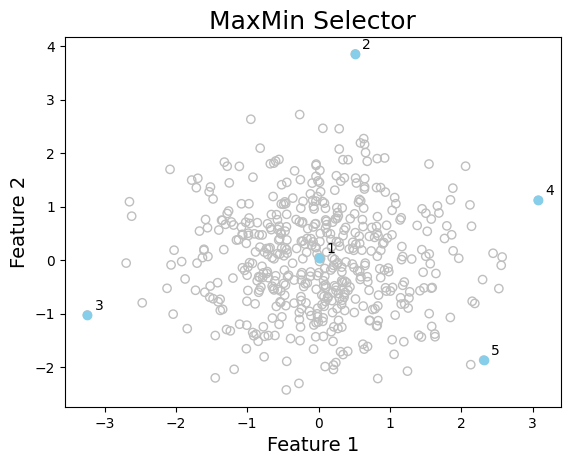

In [11]:
# select samples using X given a distance function (to compute the distance matrix)
collector = MaxMin(fun_dist=lambda x: pairwise_distances(x, metric="euclidean"))
indices_2 = collector.select(X, size=5)

# check if the selected samples are the same
assert indices_1 == indices_2

# visualize data and selected samples (in the order selected)
graph_data(
    X,
    indices=[indices_2],
    labels=None,
    title="MaxMin Selector",
    xlabel="Feature 1",
    ylabel="Feature 2",
    number=True,
)

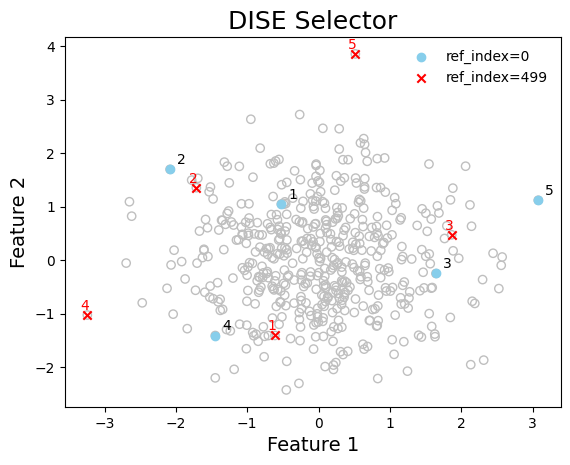

In [20]:
collector = DISE(ref_index=0, p=2)
indices_1 = collector.select(X_dist, size=5)

collector = DISE(ref_index=499, p=2)
indices_2 = collector.select(X_dist, size=5)

# visualize data and selected samples (in the order selected)
graph_data(
    X,
    indices=[indices_1, indices_2],
    labels=["ref_index=0", "ref_index=499"],
    title="DISE Selector",
    xlabel="Feature 1",
    ylabel="Feature 2",
    number=True,
)

In [21]:
# generate n_sample data in 2D feature space forming 3 clusters
X, labels = make_blobs(n_samples=500, n_features=2, centers=3, random_state=42)

# compute the (n_sample, n_sample) pairwise distance matrix
X_dist = pairwise_distances(X, metric="euclidean")

print("Shape of data   = ", X.shape)
print("Shape of labels = ", labels.shape)
print("Unique labels   = ", np.unique(labels))
size_0, size_1 = np.count_nonzero(labels == 0), np.count_nonzero(labels == 1)
print("Cluster sizes = ", size_0, size_1)
print("Shape of the distance array = ", X_dist.shape)

Shape of data   =  (500, 2)
Shape of labels =  (500,)
Unique labels   =  [0 1 2]
Cluster sizes =  167 167
Shape of the distance array =  (500, 500)


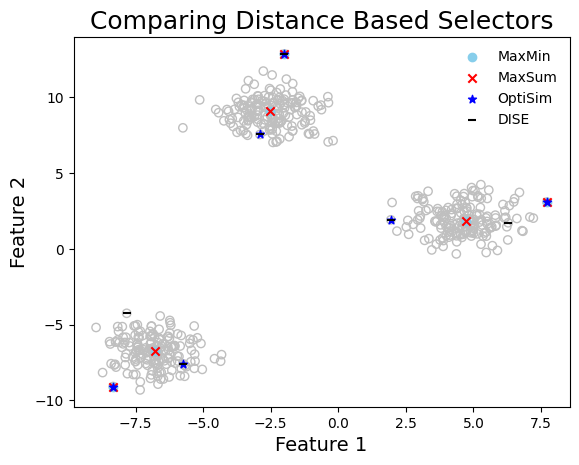

In [23]:
# select data using distance base methods with labels
# ---------------------------------------------------
size = 6

collector = MaxMin()
index_maxmin = collector.select(X_dist, size=size, labels=labels)

collector = MaxSum()
index_maxsum = collector.select(X_dist, size=size, labels=labels)

collector = OptiSim(ref_index=0, tol=0.1)
index_optisim = collector.select(X_dist, size=size, labels=labels)

collector = DISE(ref_index=0, p=2.0)
index_dise = collector.select(X, size=size, labels=labels)

graph_data(
    X,
    indices=[index_maxmin, index_maxsum, index_optisim, index_dise],
    labels=["MaxMin", "MaxSum", "OptiSim", "DISE"],
    title="Comparing Distance Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
)